In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Assignment 2, MSDS 422-58, Fall 2020, Wyatt Shackleford

## Loading and Cleaning the Data

First, I will load relevant packages for loading, cleaning, and serializing the data.

In [2]:
import numpy as np # python libary for working with arrays
import pandas as pd # data analysis tool
import matplotlib # plotting tool
import matplotlib.pyplot as plt # plotting tool
import seaborn as sns # plotting
import os 
import pickle
from pandas_profiling import ProfileReport

I will examine the files in the relevant folder for this assignment and load the appropriate data into a Pandas dataframe.

In [3]:
os.listdir('Github/repo-MSDS422-Fall-2020/assignment-2')

['.ipynb_checkpoints',
 '2-Assignment-2-Guide-v1.ipynb',
 'ames-data-info.zip',
 'amesDF.csv',
 'amesDF.pickle',
 'amesNumDFclean.pickle',
 'amesSelDF.pickle',
 'data-input-select-ex-assignment-2-v1.ipynb',
 'kmeans-assignment-2-ex-v2.ipynb',
 'rescaling-PCA-ex-assignment-2-v1.ipynb',
 'RF-example-v1.ipynb']

In [4]:
amesDF = pd.read_csv('amesDF.csv')

Examining the datatypes and column headers reveals we have a good amount of non-numeric data not relevant to our analysis. I will drop non-numeric data from the frame.

In [5]:
amesDF.columns

Index(['MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area', 'Street',
       'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities', 'Lot_Config',
       'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
       'House_Style', 'Overall_Cond', 'Year_Built', 'Year_Remod_Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Cond', 'Foundation', 'Bsmt_Cond',
       'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2',
       'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', 'First_Flr_SF', 'Second_Flr_SF',
       'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
       'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd',
       'Functional', 'Fireplaces', 'Garage_Type', 'Garage_Finish',
       'Garage_Cars', 'Garage_Area', 'Garage_Cond', 'Paved_Drive',
       'Wood_Deck_SF', 'Open_Porch_SF', 'Enclosed_Porch', 

In [6]:
amesDF.dtypes.value_counts()

object     40
int64      32
float64     2
dtype: int64

In [7]:
amesNumDF = amesDF.select_dtypes(include=np.number).astype('float')

In [8]:
amesNumDF.columns

Index(['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'Mas_Vnr_Area', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF',
       'Total_Bsmt_SF', 'First_Flr_SF', 'Second_Flr_SF', 'Gr_Liv_Area',
       'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath',
       'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd', 'Fireplaces',
       'Garage_Cars', 'Garage_Area', 'Wood_Deck_SF', 'Open_Porch_SF',
       'Enclosed_Porch', 'Three_season_porch', 'Screen_Porch', 'Pool_Area',
       'Misc_Val', 'Mo_Sold', 'Year_Sold', 'Sale_Price', 'Longitude',
       'Latitude'],
      dtype='object')

Documentation advises the use of homes under 4000 square feet. I will generate a new dataframe containing only the rows with homes under 4000 square feet.

In [9]:
amesNumDF2 = amesNumDF[amesNumDF.Gr_Liv_Area < 4000].copy()

Before proceeding I will check for issues with year values:

In [10]:
((amesNumDF2.Year_Built - amesNumDF2.Year_Sold)>0).value_counts() #sold before built?

False    2925
dtype: int64

In [11]:
((amesNumDF2.Year_Built - amesNumDF2.Year_Remod_Add)>0).value_counts() #remodeled before built?

False    2924
True        1
dtype: int64

In [12]:
((amesNumDF2.Year_Remod_Add - amesNumDF2.Year_Sold)>0).value_counts() #remodeled after sold?

False    2924
True        1
dtype: int64

I will drop the rows from the frame that are throwing the above issues.

In [13]:
amesNumDF3 = amesNumDF2.loc[~((amesNumDF2.Year_Built-amesNumDF2.Year_Remod_Add)>0),:].copy()
amesNumDF3 = amesNumDF3.loc[~((amesNumDF3.Year_Remod_Add-amesNumDF3.Year_Sold)>0),:].copy()

One of our variables, month sold (Mo_Sold) is not continuous data. I will divide it by 12 to turn it into a percentage of a year and add this column to the year sold (Year_Sold) column in order to have time of sale data in one yearly format. Because "Years" categories are "ordinal". I will convert the three year columns by subtracting them from 2010 to transform them into years before 2010.

In [14]:
amesNumDF3.loc[:,'Mo_Sold'] = amesNumDF3.loc[:, 'Mo_Sold'].div(12)

In [15]:
amesNumDF3['Year_Month'] = 2010 - amesNumDF3['Year_Sold'] + amesNumDF3['Mo_Sold']

In [16]:
amesNumDF3['Year_Built'] = 2010 - amesNumDF3['Year_Built']

In [17]:
amesNumDF3['Year_Remod_Add'] = 2010 - amesNumDF3['Year_Remod_Add']

In [18]:
amesNumDF3 = amesNumDF3.drop('Year_Sold',axis=1)

In [19]:
amesNumDF3 = amesNumDF3.drop('Mo_Sold', axis=1)


I will now generate a profile report to file to examine the interaction of potential features and assist in feature selection, in addition to examining the data for missing values or other potential sources of error.

In [20]:
AmesProfile = ProfileReport(amesNumDF3, title='Ames Profile Report')
AmesProfile.to_file('profile_report.html')

The profile report reveals a few things of note:

1) Garage areas and garage cars are highly correlated. This makes sense as the larger the area of the garage, the more cars that can fit. However, using these two highly correlated values may create issues and I will opt to use the garage area as a feature and drop the garage cars variable as the garage area is a more specific feature in regards to available garage space.

2) First Floor Square footage is highly correlated with basement Square footage. Again this makes sense from a layout standpoint, however given that basements are not guarenteed and have a potential effect on home value, I will retain both features. 

3) No home under 4000 square feet has a pool area. I will drop this as a feature.

4) Basement half-baths, miscellaneous value, enclosed porch, screen porch, and three season porch are almost all "zero's" meaning that very few homes under 4000 sq ft have any of these features. They will be dropped from the data frame.

5) Basement sq ft 1 and 2 are portions of basement total sq ft and will be dropped.

6) Half baths and full baths can be combined into one variable titled bathrooms.


The following code makes these alterations and serializes this dataframe into a .pickle format that can be used in future sessions.

In [21]:
amesSelDF = pd.DataFrame(amesNumDF3)

In [22]:
amesSelDF['Bathrooms'] = amesSelDF['Full_Bath'] + (amesSelDF['Half_Bath']/2)

In [23]:
amesSelDF = amesSelDF.drop('Bsmt_Half_Bath', axis=1)
amesSelDF = amesSelDF.drop('Bsmt_Full_Bath', axis=1)
amesSelDF = amesSelDF.drop('Full_Bath', axis=1)
amesSelDF = amesSelDF.drop('Half_Bath', axis=1)
amesSelDF = amesSelDF.drop('Enclosed_Porch', axis=1)
amesSelDF = amesSelDF.drop('Three_season_porch', axis=1)
amesSelDF = amesSelDF.drop('Screen_Porch', axis=1)
amesSelDF= amesSelDF.drop('Pool_Area', axis=1)
amesSelDF= amesSelDF.drop('Misc_Val', axis=1)
amesSelDF = amesSelDF.drop('Garage_Cars', axis=1)
amesSelDF = amesSelDF.drop('Longitude', axis=1)
amesSelDF = amesSelDF.drop('Latitude', axis=1)
amesSelDF = amesSelDF.drop('BsmtFin_SF_1', axis=1)
amesSelDF = amesSelDF.drop('BsmtFin_SF_2', axis=1)
amesSelDF.to_pickle('amesSel.pickle')

## Objective 1: K-Means Clustering

First I will load relevant packages for K-Means Clustering, plotting, and evaluating K-Means.

In [24]:
from sklearn.cluster import KMeans, MiniBatchKMeans
%matplotlib inline
import scikitplot as skplt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

Taking a look back at the Ames Dataset selected features to see column heads and examine means, std, min, quartiles, and maxes.

In [25]:
amesSelDF.columns

Index(['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'Mas_Vnr_Area', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'First_Flr_SF',
       'Second_Flr_SF', 'Gr_Liv_Area', 'Bedroom_AbvGr', 'Kitchen_AbvGr',
       'TotRms_AbvGrd', 'Fireplaces', 'Garage_Area', 'Wood_Deck_SF',
       'Open_Porch_SF', 'Sale_Price', 'Year_Month', 'Bathrooms'],
      dtype='object')

In [26]:
amesSelDF.describe()

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Sale_Price,Year_Month,Bathrooms
count,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000
mean,57.432090,10101.123503,38.719808,25.779678,99.963736,558.538488,1046.179610,1155.216558,333.866233,1493.770783,2.853575,1.044475,6.434143,0.596989,471.598700,93.406774,47.059528,180376.578857,2.726822,1.753678
std,33.056313,7783.707985,30.240274,20.861970,175.615503,439.352262,421.449895,376.600344,425.920517,486.286774,0.828011,0.214321,1.558364,0.645432,213.969258,126.061952,66.329353,78566.782806,1.371004,0.640747
min,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,12789.000000,0.083333,0.000000
25%,43.000000,7437.000000,10.000000,6.000000,0.000000,218.500000,792.000000,876.000000,0.000000,1125.500000,2.000000,1.000000,5.000000,0.000000,320.000000,0.000000,0.000000,129450.000000,1.583333,1.000000
50%,63.000000,9416.000000,37.000000,17.000000,0.000000,464.000000,988.000000,1082.000000,0.000000,1441.000000,3.000000,1.000000,6.000000,1.000000,480.000000,0.000000,26.000000,160000.000000,2.666667,2.000000
75%,78.000000,11513.500000,56.000000,45.000000,162.000000,801.000000,1298.000000,1382.500000,702.500000,1740.000000,3.000000,1.000000,7.000000,1.000000,576.000000,168.000000,70.000000,213495.000000,3.833333,2.250000
max,313.000000,215245.000000,138.000000,60.000000,1600.000000,2336.000000,3206.000000,3820.000000,1862.000000,3820.000000,8.000000,3.000000,14.000000,4.000000,1488.000000,1424.000000,742.000000,625000.000000,5.000000,5.000000


We have to separate Sale_Price from the features we will use here, I will do this now as well as dropping Year_Month Sold, Year_Built, and Year_Remod_Add from the frame.

In [27]:
amesClusDF = amesSelDF.loc[:, ~(amesSelDF.columns.isin(['Sale_Price']))].astype('float32')
amesClusDF = amesClusDF.drop('Year_Month', axis=1)
amesClusDF = amesClusDF.drop('Year_Built', axis=1)
amesClusDF = amesClusDF.drop('Year_Remod_Add', axis=1)
amesClusDF.dtypes
X = amesClusDF.to_numpy(copy=True)

Lot_Frontage     float32
Lot_Area         float32
Mas_Vnr_Area     float32
Bsmt_Unf_SF      float32
Total_Bsmt_SF    float32
First_Flr_SF     float32
Second_Flr_SF    float32
Gr_Liv_Area      float32
Bedroom_AbvGr    float32
Kitchen_AbvGr    float32
TotRms_AbvGrd    float32
Fireplaces       float32
Garage_Area      float32
Wood_Deck_SF     float32
Open_Porch_SF    float32
Bathrooms        float32
dtype: object

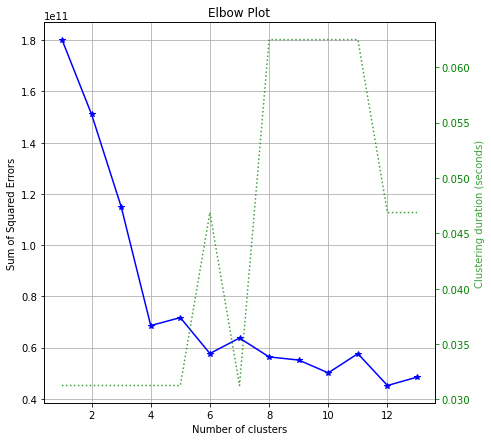

In [28]:
kmMB = MiniBatchKMeans(random_state=88)
skplt.cluster.plot_elbow_curve(kmMB, X, n_jobs=-1, cluster_ranges=range(1,14),
                               figsize=(7,7))
plt.show();

The elbow plot suggests that 3 clusters may be most appropriate number of clusters as the "elbow" takes place at 3 clusters. 

* I would have liked to do a gridsearch here, but could not figure out how to get the Davies Bouldin Score to work as a scoring criterion. See the below raw code. I tried creating a custom scorer as well, however it continuously asked for yTrue which we obviously do not have.

I will now perform the K-Means analysis, predicting cluster membership by the above features stored in object X. Given that the above elbow plot demonstrates that 2 to 4 options is most appropriate, I will omit other options from the document.

* Note I did run each potential cluster between 2-12, however for the sake of space and given the elbow plot above and the dramatic rise in variance as cluster number goes up, it seems like this would be repetitive.

In [29]:
kmeans = KMeans(n_clusters=2, random_state=33).fit(X)
label = kmeans.predict(X)
pd.Series(label).value_counts()
CH2 = calinski_harabasz_score(X,label)
DB2 = davies_bouldin_score(X,label)
S2 = silhouette_score(X, label)
kmeans = KMeans(n_clusters=3, random_state=33).fit(X)
label = kmeans.predict(X)
pd.Series(label).value_counts()
CH3 = calinski_harabasz_score(X,label)
DB3 = davies_bouldin_score(X,label)
S3 = silhouette_score(X, label)
kmeans = KMeans(n_clusters=4, random_state=33).fit(X)
label = kmeans.predict(X)
pd.Series(label).value_counts()
CH4 = calinski_harabasz_score(X,label)
DB4 = davies_bouldin_score(X,label)
S4 = silhouette_score(X, label)


ModelSummaryData = {'Number of Clusters':pd.Series(['2', '3', '4']),
    'Calinski Harabasz':pd.Series([CH2, CH3, CH4]),
    'Davies Bouldin': pd.Series([DB2,DB3,DB4]),
    'Silhouette': pd.Series([S2,S3,S4])}
Summary_df = pd.DataFrame(ModelSummaryData)
print(Summary_df)

0    2919
1       4
dtype: int64

0    2820
1      99
2       4
dtype: int64

2    1832
0    1055
3      32
1       4
dtype: int64

  Number of Clusters  Calinski Harabasz  Davies Bouldin  Silhouette
0                  2        3210.901192        0.194739    0.965724
1                  3        3666.211631        0.494158    0.760428
2                  4        4794.093274        0.576367    0.447347


This summary table reveals that clusters 2 or 3 produce robust silhouette scores (larger than .71 according to Izenman, p.423). This indicates that clusters=2 or 3 are well clustered and good choices. As both of these options present as robust, I will examine these by the other two metrics, Davies Bouldin and Calinski Harabasz scores. Davies Bouldin scores are better when smaller as they are representations of similarity between clusters, or intra-cluster similarity, two clusters dramatically reduces the Davies Bouldin Score compared to 3 clusters, seeming to indicate that when two clusters are used their intra-cluster similarity dramatically decreases. However, with 2 clusters there are only 4 points in one of the clusters. This seems unrealistic and maybe why we are seeing such a dramatically low Davies Bouldin score. Looking at Calinski Harabasz score, a ratio between inter and intra cluster dispersion, three clusters presents as a better option than 2 indicating that it has higher inter-cluster variance and/or lower intra-cluster variance. While four clusters increases the Calinski-Harabasz score and only slightly increases the Davies Bouldin Score, the fact that its Silhouette score presents as weak and or artificial, solidifies in my mind the idea that the elbow plot was correct and three clusters is most appropriate for this model. See the below silhouette plot with three clusters:

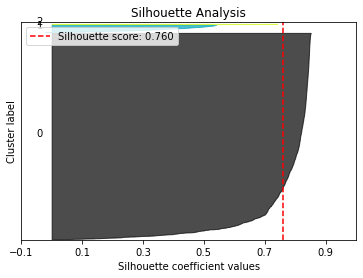

In [30]:
kmeans = KMeans(n_clusters=3, random_state=33).fit(X)
label = kmeans.predict(X)
pd.Series(label).value_counts()
skplt.metrics.plot_silhouette(X, label)
plt.show();

## Objective 2: Rescaling Feature Data

First I will load the appropriate package to create a train/test split, transform the data using standardization, and partition the data into an 85%/15% split

In [31]:
from sklearn.model_selection import train_test_split
X= amesSelDF.loc[:, ~(amesSelDF.columns.isin(['Sale_Price']))].to_numpy(copy=True)
y= amesSelDF.Sale_Price.to_numpy(copy=True)
X.shape
y.shape

(2923, 19)

(2923,)

In [32]:
trainX,testX,trainY,testY = train_test_split(X,y,test_size=.15, random_state=33)

Now I will load a Standardization Scaler, entitle it scaler and fit it to my training X data before transforming the training and testing data using this scaler.

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(trainX)
trainXS=scaler.transform(trainX)
testXS=scaler.transform(testX)

MinMaxScaler()

Taking a look at the scaled data:

In [34]:
pd.DataFrame(trainXS).describe()
pd.DataFrame(testXS).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000
mean,0.286361,0.041465,0.281398,0.429804,0.071654,0.238037,0.326320,0.236710,0.176037,0.332168,0.355878,0.349973,0.368223,0.148551,0.316713,0.066032,0.063424,0.535365,0.350765
std,0.162620,0.038645,0.219956,0.346490,0.127682,0.190401,0.134415,0.109481,0.227689,0.140041,0.104636,0.074433,0.129287,0.162181,0.143732,0.088644,0.089243,0.278160,0.128419
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.215000,0.028538,0.072464,0.100000,0.000000,0.089897,0.243918,0.154905,0.000000,0.226621,0.250000,0.333333,0.250000,0.000000,0.216398,0.000000,0.000000,0.305085,0.200000
50%,0.310000,0.037996,0.260870,0.283333,0.000000,0.196704,0.308796,0.216294,0.000000,0.318560,0.375000,0.333333,0.333333,0.250000,0.322581,0.000000,0.036388,0.525424,0.400000
75%,0.390000,0.047676,0.413043,0.750000,0.109035,0.340860,0.408609,0.304719,0.374463,0.400244,0.375000,0.333333,0.416667,0.250000,0.387097,0.117978,0.094340,0.745763,0.400000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000
mean,0.291686,0.039282,0.275940,0.428853,0.077573,0.245117,0.326313,0.229159,0.197797,0.335672,0.361333,0.337889,0.376803,0.153189,0.318187,0.063117,0.063416,0.550635,0.350569
std,0.179731,0.018974,0.214601,0.354866,0.126104,0.174439,0.113411,0.099313,0.234025,0.136495,0.096816,0.050160,0.132992,0.156740,0.144318,0.087919,0.090340,0.282682,0.126756
min,0.000000,0.000823,0.000000,0.000000,0.000000,0.000000,0.000000,0.042742,0.000000,0.045324,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.210000,0.029012,0.057971,0.100000,0.000000,0.113656,0.259513,0.160069,0.000000,0.230063,0.250000,0.333333,0.250000,0.000000,0.208333,0.000000,0.000000,0.313559,0.200000
50%,0.320000,0.037743,0.275362,0.266667,0.000000,0.214469,0.306301,0.209409,0.000000,0.310958,0.375000,0.333333,0.333333,0.250000,0.316532,0.000000,0.032345,0.576271,0.400000
75%,0.392500,0.048148,0.405797,0.758333,0.141509,0.349315,0.381316,0.285141,0.407626,0.417958,0.375000,0.333333,0.416667,0.250000,0.391465,0.117978,0.095687,0.779661,0.500000
max,1.565000,0.152764,0.833333,1.000000,1.161103,0.907962,0.766687,0.686173,0.874866,0.766208,0.750000,0.666667,0.833333,0.750000,0.772849,0.511236,0.768194,1.000000,0.700000


## Objective 3: PCA

Before beginning Principal Component Analysis I will load the relevant package:

In [35]:
from sklearn.decomposition import PCA

Using PCA and designating n_components = .8, with the solver method being 'full', the PCA will return the components necessary to explain 80% of the variation in the data. I will fit the pca accounting for 80% of variation to the trainXS set and then apply dimensionality reduction to the trainX and testX data saving these as trainXPCA and testXPCA, before displaying the shape of the transformed data and the proportion of variance explained by each component.

In [36]:
pca80 = PCA(n_components=.8, svd_solver='full')
pca80.fit(trainXS)
trainXPCA=pca80.transform(trainX)
testXPCA=pca80.transform(testX)

PCA(n_components=0.8, svd_solver='full')

In [37]:
trainXPCA.shape

(2484, 6)

In [38]:
print(f'prop. of variance explained: {(pca80.explained_variance_ratio_)}')

prop. of variance explained: [0.31865304 0.14886942 0.13871308 0.09940857 0.06638635 0.04816556]


The first 6 components account for over 80% of the variation in the data. We now have two variables, trainXPCA and testXPCA, that I will use for an adaBoost model later in the document. Displaying the PCA components, it is evident that only the first principal component is needed to meet the 80% threshold.

PCA(random_state=33, svd_solver='full')

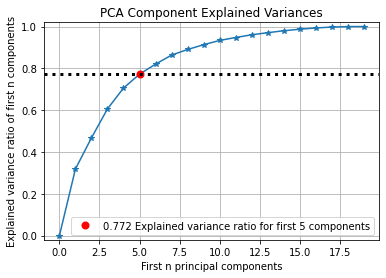

In [39]:
pca = PCA(random_state=33, svd_solver='full')
pca.fit(trainXS)
skplt.decomposition.plot_pca_component_variance(pca)
plt.show()

The PCA on our Min-Max scaled training data reveals a need for 6 components in order to meet the threshold of 80% explained variance.

## Objective 4: Training RF Regressors

First I will import relevant packages for train/test split, randomforest, and r2 score

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

I will create a new dataframe for the Random Forest Regression and drop features that will not be used in the analysis.

In [41]:
amesSelDF2 = pd.DataFrame(amesNumDF3)

In [42]:
amesSelDF2 = amesSelDF2.drop('Bsmt_Half_Bath', axis=1)
amesSelDF2 = amesSelDF2.drop('Bsmt_Full_Bath', axis=1)
amesSelDF2 = amesSelDF2.drop('Full_Bath', axis=1)
amesSelDF2 = amesSelDF2.drop('Half_Bath', axis=1)
amesSelDF2 = amesSelDF2.drop('Enclosed_Porch', axis=1)
amesSelDF2 = amesSelDF2.drop('Three_season_porch', axis=1)
amesSelDF2 = amesSelDF2.drop('Screen_Porch', axis=1)
amesSelDF2= amesSelDF2.drop('Pool_Area', axis=1)
amesSelDF2= amesSelDF2.drop('Misc_Val', axis=1)
amesSelDF2 = amesSelDF2.drop('Garage_Cars', axis=1)
amesSelDF2 = amesSelDF2.drop('Longitude', axis=1)
amesSelDF2 = amesSelDF2.drop('Latitude', axis=1)
amesSelDF2 = amesSelDF2.drop('BsmtFin_SF_1', axis=1)
amesSelDF2 = amesSelDF2.drop('BsmtFin_SF_2', axis=1)
amesSelDF2.to_pickle('amesSel2.pickle')

Again dropping any rows that have general living area greater than 4000.

In [43]:
rfDF = amesSelDF2[amesSelDF2.Gr_Liv_Area<4000].copy()

I will move the Sale Price variable into the y object and the rest of the selected features into the X object and examine their shapes to ensure they are in the proper format.

In [44]:
y = rfDF.Sale_Price.to_numpy(copy=True)
X = amesClusDF
X.shape
y.shape

(2923, 16)

(2923,)

The shapes are appropriate and I will seperate them into an 80/20 train/test split

In [45]:
XTrain, XTest, yTrain, yTest = train_test_split(X,y, test_size=.2, random_state=11)
trainTestData=[XTrain, XTest, yTrain, yTest]
XTrain.shape, XTest.shape

((2338, 16), (585, 16))

Now that the data is partitioned, I will perform a Random Forest Regression and display Training, OOB, and Test Data R2 values.

In [46]:
RFregr = RandomForestRegressor(n_estimators = 1000, max_features='log2', oob_score=True, n_jobs=-1, random_state=11)
RFregr.fit(XTrain,yTrain)
print(f'RF R\u00b2, Training: {RFregr.score(XTrain, yTrain):5.3f}')
print(f'RF R\u00b2, OOB: {RFregr.oob_score_:5.3f}')
predTesty = RFregr.predict(XTest)
print(f'Test Data R\u00b2: {r2_score(yTest, predTesty):4.3f}')

RandomForestRegressor(max_features='log2', n_estimators=1000, n_jobs=-1,
                      oob_score=True, random_state=11)

RF R², Training: 0.981
RF R², OOB: 0.857
Test Data R²: 0.868


The model is overtrained as it displays a training R2 score in training of .981 and a test R2 of only .868. Examining feature importance below gives the feature importance for each feature included in the model. I will change my max_features to sqrt which will reduce the number of features to consider, alter my max_depth to 7 from the default of None which will reduce how deep nodes go before expanded.

In [47]:
RFregr = RandomForestRegressor(n_estimators = 1000, max_depth= 7, max_features='sqrt', oob_score=True, n_jobs=-1, random_state=11)
RFregr.fit(XTrain,yTrain)
print(f'RF R\u00b2, Training: {RFregr.score(XTrain, yTrain):5.3f}')
print(f'RF R\u00b2, OOB: {RFregr.oob_score_:5.3f}')
predTesty = RFregr.predict(XTest)
print(f'Test Data R\u00b2: {r2_score(yTest, predTesty):4.3f}')

RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=1000,
                      n_jobs=-1, oob_score=True, random_state=11)

RF R², Training: 0.908
RF R², OOB: 0.839
Test Data R²: 0.851


These changes drop the training R^2 and Test R^2, while it reduces overfitting it doesn't seem to dramatically alter the performance of the model on testing data. Below are the relevant feature importances:

In [48]:
RFFeatImpDF = pd.DataFrame({'feature': X,
                            'importance':RFregr.feature_importances_})
RFFeatImpDF

,feature,importance
0,"(L, o, t, _, F, r, o, n, t, a, g, e)",0.014651
1,"(L, o, t, _, A, r, e, a)",0.022005
2,"(M, a, s, _, V, n, r, _, A, r, e, a)",0.049155
3,"(B, s, m, t, _, U, n, f, _, S, F)",0.009617
4,"(T, o, t, a, l, _, B, s, m, t, _, S, F)",0.179421
5,"(F, i, r, s, t, _, F, l, r, _, S, F)",0.106128
6,"(S, e, c, o, n, d, _, F, l, r, _, S, F)",0.037183
7,"(G, r, _, L, i, v, _, A, r, e, a)",0.188165
8,"(B, e, d, r, o, o, m, _, A, b, v, G, r)",0.012624
9,"(K, i, t, c, h, e, n, _, A, b, v, G, r)",0.010737


## Objective 5: Training Boosted Regression

First I will import the AdaBoostRegressor from sklearn before choosing the number of estimators and learning rate and storing the model under 'AdaBst'. I will use hold out validation as a method for validating the model using the aforementioned 80/20 partition from the train/test split earlier in the document.

In [49]:
from sklearn.ensemble import AdaBoostRegressor

In [50]:
AdaBst = AdaBoostRegressor(base_estimator=None, n_estimators=100, learning_rate=.32, loss='linear', random_state=22)

Fitting this AdaBst model to the training data and then generating a score for the training data reveals:

In [51]:
AdaBst.fit(trainX, trainY)
print(f' Training R\u00b2: {AdaBst.score(trainX,trainY)}')

AdaBoostRegressor(learning_rate=0.32, n_estimators=100, random_state=22)

 Training R²: 0.8516257698020803


Now, predicting Y for the testing data based on the testX variable and looking at the score for how this predicted model performs:

In [52]:
predY = AdaBst.predict(testX)

In [53]:
print(f' Testing R\u00b2: {r2_score(testY, predY)}')

 Testing R²: 0.8244316952175847


Overall, while slightly overfit, this model seems to perform comparably to the other methods used in this document. I will perform this same methodology again using the PCA transformed data from earlier in the document.

In [54]:
AdaBstPCA = AdaBoostRegressor(base_estimator=None, n_estimators=100, learning_rate=.32, loss='linear', random_state=22)

In [55]:
AdaBstPCA.fit(trainXPCA, trainY)
print(f' Training R\u00b2: {AdaBstPCA.score(trainXPCA,trainY)}')

AdaBoostRegressor(learning_rate=0.32, n_estimators=100, random_state=22)

 Training R²: 0.7827226328493484


In [56]:
testYPCA = AdaBstPCA.predict(testXPCA)
print(f'Testing R\u00b2: {r2_score(testY, testYPCA)}')

Testing R²: 0.728465567000768


This model performs similarly in regard to the fact that it is overfit, however it has lower training and testing scores than those before it. The min-max scaled data performs better than if the scaled data was standardized, however only marginally so. It seems that using the components reduced the ability of the model to explain variance in the data which would seem to make sense considering it is based on the PCA which reduced the components down in order to explain only above 80% of the variance. 